# ☕ Análise de Vendas de Café
# Dataset: `coffee_sales.csv` – Vendas de uma cafeteria (2024–2025)

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from datetime import datetime

In [5]:
# Configurações de estilo

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [10]:
# Leitura do arquivo

with open('../data/coffee_sales.csv', 'r') as f:
    raw_data = f.read()

In [11]:
# Expressão regular para extrair registros

pattern = r'(\d{4}-\d{2}-\d{2}),(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}\.\d{3}),(card|cash),([^,]*),([\d.]+),([^,]+?)(?=\d{4}-\d{2}-\d{2}|$)'
matches = re.findall(pattern, raw_data)

In [13]:
# Criação do DataFrame

df = pd.DataFrame(matches, columns=['Date', 'Timestamp', 'Payment Method', 'Customer ID', 'Price', 'Product'])


In [14]:
# Conversão de tipos

df['Date'] = pd.to_datetime(df['Date'])
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['Price'] = df['Price'].astype(float)
df['Product'] = df['Product'].str.strip()

print(f"✅ {len(df)} registros carregados.")

✅ 3636 registros carregados.


In [29]:
# Extrair hora do Timestamp
# Para definir em qual período do dia

df['Hour'] = df['Timestamp'].dt.hour

# Definir função para classificar o período do dia
def classify_period(hour):
    if 5 <= hour < 12:
        return 'Manhã'
    elif 12 <= hour < 18:
        return 'Tarde'
    else:
        return 'Noite'

# Aplicar a classificação
df['Periodo_do_Dia'] = df['Hour'].apply(classify_period)

print("✅ Coluna 'Periodo_do_Dia' criada com base no horário.")

✅ Coluna 'Periodo_do_Dia' criada com base no horário.


In [20]:
# Informações gerais

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3636 entries, 0 to 3635
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            3636 non-null   datetime64[ns]
 1   Timestamp       3636 non-null   datetime64[ns]
 2   Payment Method  3636 non-null   object        
 3   Customer ID     3636 non-null   object        
 4   Price           3636 non-null   float64       
 5   Product         3636 non-null   object        
 6   Hour            3636 non-null   int32         
 7   Periodo_do_Dia  3636 non-null   object        
dtypes: datetime64[ns](2), float64(1), int32(1), object(4)
memory usage: 213.2+ KB


,Date,Timestamp,Payment Method,Customer ID,Price,Product,Hour,Periodo_do_Dia
0,2024-03-01,2024-03-01 10:15:50.520,card,client-0001,38.7,Latte,10,Manhã
1,2024-03-01,2024-03-01 12:19:22.539,card,client-0002,38.7,Hot Chocolate,12,Tarde
2,2024-03-01,2024-03-01 12:20:18.089,card,client-0002,38.7,Hot Chocolate,12,Tarde
3,2024-03-01,2024-03-01 13:46:33.006,card,client-0003,28.9,Americano,13,Tarde
4,2024-03-01,2024-03-01 13:48:14.626,card,client-0004,38.7,Latte,13,Tarde


In [18]:
# === Transformar o Customer ID ===

def convert_customer_id(anon_id):
    match = re.search(r'ANON-\d{4}-\d{4}-(\d{4})', anon_id)
    if match:
        number = match.group(1)
        return f'client-{number}'
    return anon_id  # caso não bata com o padrão

# Aplicar a transformação
df['Customer ID'] = df['Customer ID'].apply(convert_customer_id)

# Verificar resultado
print(df[['Customer ID']].head(10))

   Customer ID
0  client-0001
1  client-0002
2  client-0002
3  client-0003
4  client-0004
5  client-0005
6  client-0006
7  client-0007
8  client-0008
9  client-0008


In [21]:
# Salvar em CSV com os novos IDs
df.to_csv('coffee_sales_clean_client.csv', index=False)
print("✅ Arquivo salvo com novos Customer IDs!")

✅ Arquivo salvo com novos Customer IDs!


In [23]:
# Contar valores vazios ou nulos

missing_ids = df['Customer ID'].isin(['', ' ', None, 'ANON-0000-0000-']) | df['Customer ID'].isna()
num_missing = missing_ids.sum()

print(f"Total de registros: {len(df)}")
print(f"Registros com Customer ID em branco ou inválido: {num_missing}")
print(f"Percentual: {num_missing / len(df) * 100:.2f}%")

Total de registros: 3636
Registros com Customer ID em branco ou inválido: 89
Percentual: 2.45%


In [24]:
# Filtrar linhas com Customer ID em branco
df_missing = df[missing_ids]

print("\nInformações sobre registros com Customer ID em branco:")
print(df_missing['Payment Method'].value_counts())
print("\nProdutos mais comuns nesses casos:")
print(df_missing['Product'].value_counts())
print("\nPreço médio:")
print(f"R$ {df_missing['Price'].mean():.2f}")


Informações sobre registros com Customer ID em branco:
Payment Method
cash    89
Name: count, dtype: int64

Produtos mais comuns nesses casos:
Product
Latte                  25
Americano with Milk    15
Cappuccino             15
Americano              14
Hot Chocolate           6
Cortado                 5
Espresso                5
Cocoa                   4
Name: count, dtype: int64

Preço médio:
R$ 35.80


In [25]:
# Substituir por um ID genérico
df['Customer ID'] = df['Customer ID'].replace(['', ' ', None], 'CASH-CLIENT')

# Garantir que todos os valores nulos sejam preenchidos
df['Customer ID'] = df['Customer ID'].fillna('CASH-CLIENT')

print("✅ Customer ID em branco substituídos por 'CASH-CLIENT'")

✅ Customer ID em branco substituídos por 'CASH-CLIENT'


In [26]:
# Comparar comportamento
print("Compradores com ID registrado:")
print(f"  - Média de preço: R$ {df[df['Customer ID'] != 'CASH-CLIENT']['Price'].mean():.2f}")

print("Compradores em dinheiro (CASH-CLIENT):")
print(f"  - Média de preço: R$ {df[df['Customer ID'] == 'CASH-CLIENT']['Price'].mean():.2f}")

Compradores com ID registrado:
  - Média de preço: R$ 31.65
Compradores em dinheiro (CASH-CLIENT):
  - Média de preço: R$ 35.80


In [27]:
def convert_id(x):
    if x == 'CASH-CLIENT':
        return 'CASH-CLIENT'
    match = re.search(r'ANON-\d{4}-\d{4}-(\d{4})', x)
    if match:
        return f'client-{match.group(1)}'
    return x

df['Customer ID'] = df['Customer ID'].apply(convert_id)

In [30]:
# Estatísticas descritivas

df.describe()

,Date,Timestamp,Price,Hour
count,3636,3636,3636.000000,3636.000000
mean,2024-09-30 11:56:02.376237568,2024-10-01 02:35:30.535053568,31.746859,14.166667
min,2024-03-01 00:00:00,2024-03-01 10:15:50.520000,18.120000,6.000000
25%,2024-07-03 00:00:00,2024-07-03 16:54:06.084750080,27.920000,10.000000
50%,2024-10-06 12:00:00,2024-10-07 02:55:12.649500160,32.820000,14.000000
75%,2025-01-08 00:00:00,2025-01-08 07:55:20.299750144,35.760000,18.000000
max,2025-03-23 00:00:00,2025-03-23 18:11:38.635000,40.000000,22.000000
std,NaN,NaN,4.919926,4.227603


In [37]:
# 1. Verificar se o DataFrame foi criado
if df is None:
    print("❌ O DataFrame não foi criado corretamente.")
else:
    print("✅ DataFrame carregado com sucesso!")
    print(f"Forma: {df.shape}")

    # 2. Verificar valores nulos (NaN) e em branco ('' ou ' ')
    print("\n🔍 Valores ausentes por coluna:")

    # Verifica: string vazia, espaço em branco, ou NaN
    missing = (df == '') | (df == ' ') | df.isna()

    # Mostrar contagem por coluna
    print(missing.sum())

    # 3. Resumo geral
    total_missing = missing.sum().sum()
    print(f"\n📊 Total de células com dados em branco ou nulos: {total_missing}")

    if total_missing == 0:
        print("✅ Nenhum dado faltante encontrado.")
    else:
        print("⚠️  Detalhes dos registros com dados faltantes:")
        display(df[missing.any(axis=1)])  # Mostra linhas com pelo menos 1 valor faltante

✅ DataFrame carregado com sucesso!
Forma: (3636, 8)

🔍 Valores ausentes por coluna:
Date              0
Timestamp         0
Payment Method    0
Customer ID       0
Price             0
Product           0
Hour              0
Periodo_do_Dia    0
dtype: int64

📊 Total de células com dados em branco ou nulos: 0
✅ Nenhum dado faltante encontrado.


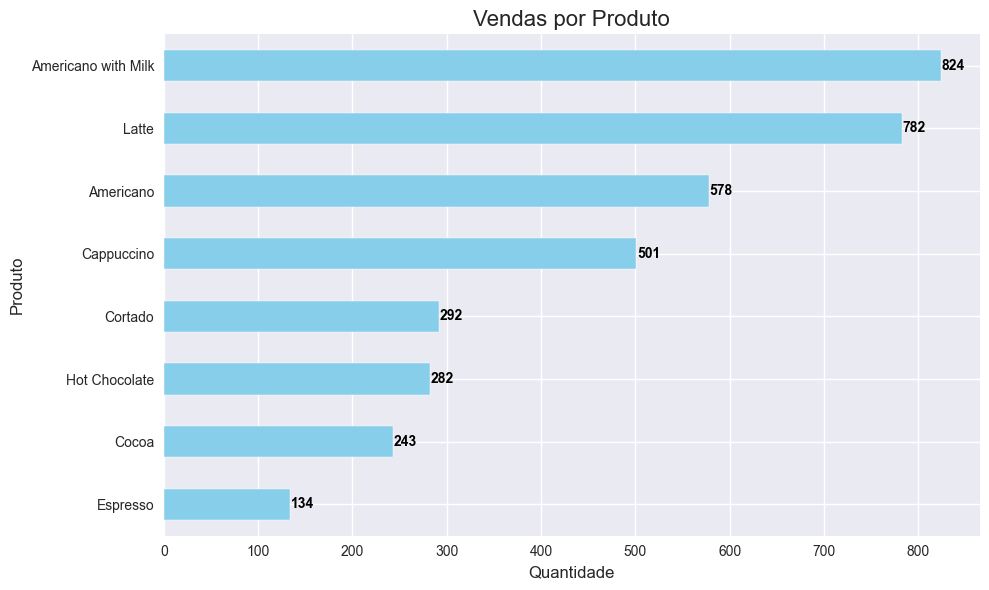

In [21]:
# Produtos mais vendidos

import os
plt.figure(figsize=(10, 6))

ax = df['Product'].value_counts().plot(kind='barh', color='skyblue')

plt.title('Vendas por Produto', fontsize=16)
plt.xlabel('Quantidade', fontsize=12)
plt.ylabel('Produto', fontsize=12)

for index, value in enumerate(df['Product'].value_counts().values):
    ax.text(value + 0.5, index, str(value), va='center', fontsize=10, color='black', fontweight='bold')

ax.invert_yaxis()
plt.tight_layout()

os.makedirs('../outputs/figures', exist_ok=True)
plt.savefig('../outputs/figures/sales_by_product.png', dpi=150)

plt.show()

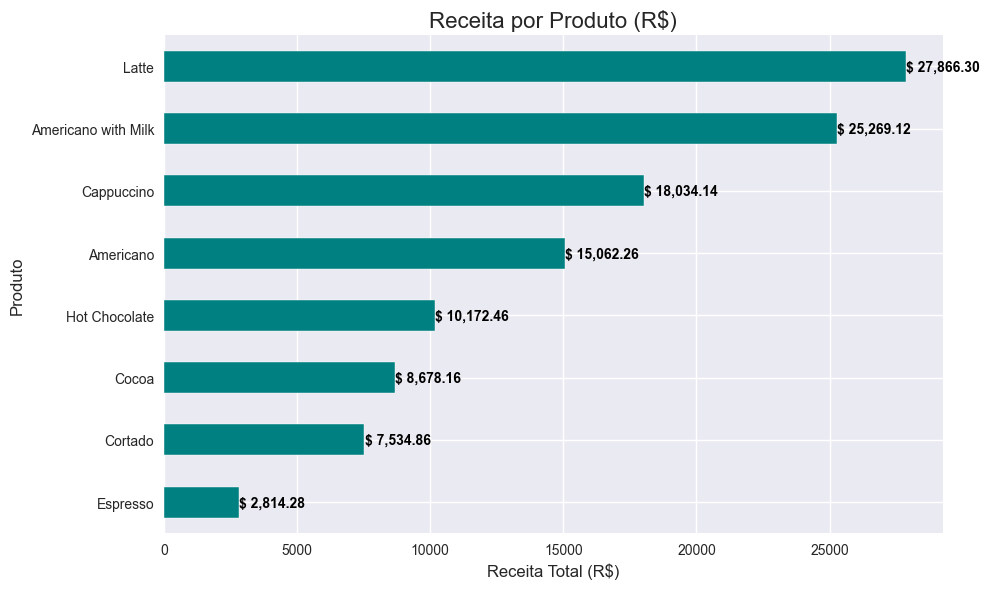

In [27]:
# Receita por produto com valores visíveis

plt.figure(figsize=(10, 6))

ax = df.groupby('Product')['Price'].sum().sort_values().plot(kind='barh', color='teal')

plt.title('Receita por Produto (R$)', fontsize=16)
plt.xlabel('Receita Total (R$)', fontsize=12)
plt.ylabel('Produto', fontsize=12)

revenue = df.groupby('Product')['Price'].sum().sort_values()
for index, value in enumerate(revenue):
    ax.text(value + 0.5, index, f'$ {value:,.2f}', va='center', fontsize=10, color='black', fontweight='bold')

plt.tight_layout()

os.makedirs('../outputs/figures', exist_ok=True)
plt.savefig('../outputs/figures/revenue_by_product.png', dpi=150)

plt.show()

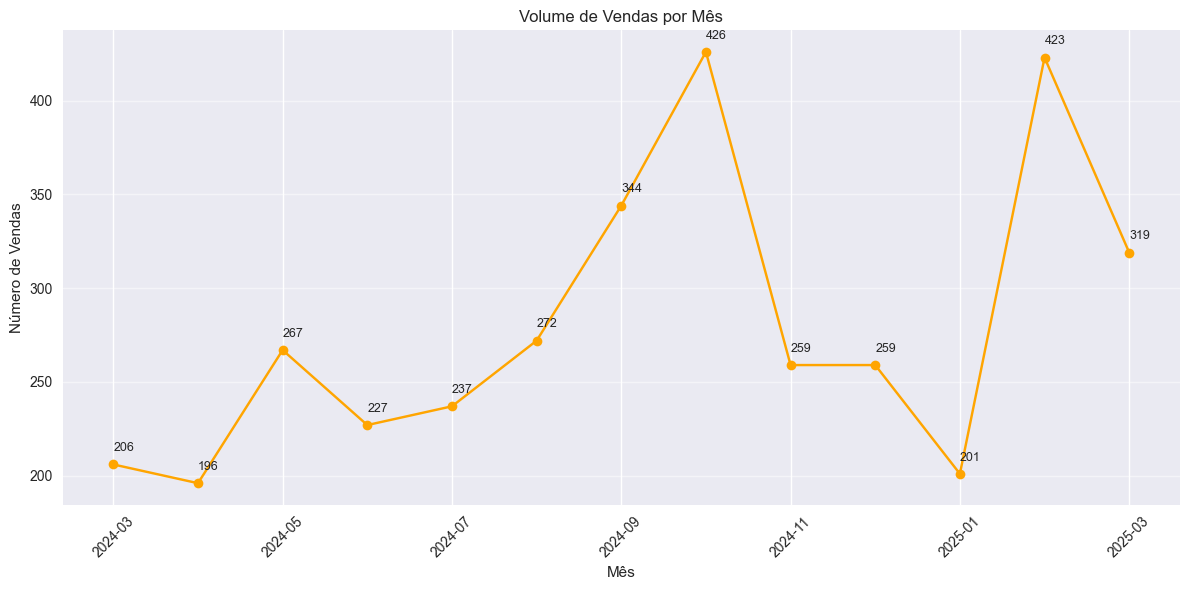

In [48]:
# Evolução mensal de vendas

df['Month'] = df['Date'].dt.to_period('M')
monthly_sales = df.groupby('Month').size()
monthly_sales.index = monthly_sales.index.astype(str)

plt.figure(figsize=(12, 6))
ax = monthly_sales.plot(kind='line', marker='o', color='orange')

for i, value in enumerate(monthly_sales):
    ax.text(i, value + 5.5, str(value), ha='left', va='bottom', fontsize=9)

plt.title('Volume de Vendas por Mês')
plt.xlabel('Mês')
plt.ylabel('Número de Vendas')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.5)
plt.tight_layout()
plt.savefig('../outputs/figures/sales_over_time.png', dpi=150)
plt.show()


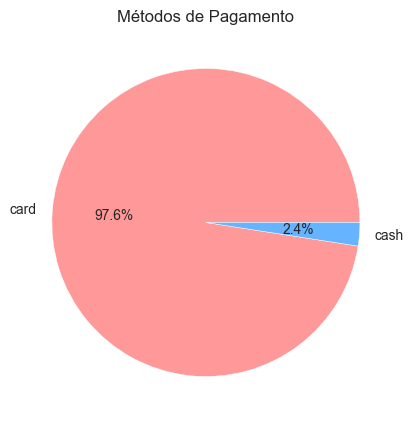

In [28]:
# Métodos de pagamento

payment = df['Payment Method'].value_counts()
plt.figure(figsize=(7, 5))
plt.pie(payment, labels=payment.index, autopct='%1.1f%%', colors=['#ff9999','#66b3ff'])
plt.title('Métodos de Pagamento')
plt.savefig('../outputs/figures/payment_method.png', dpi=150)
plt.show()

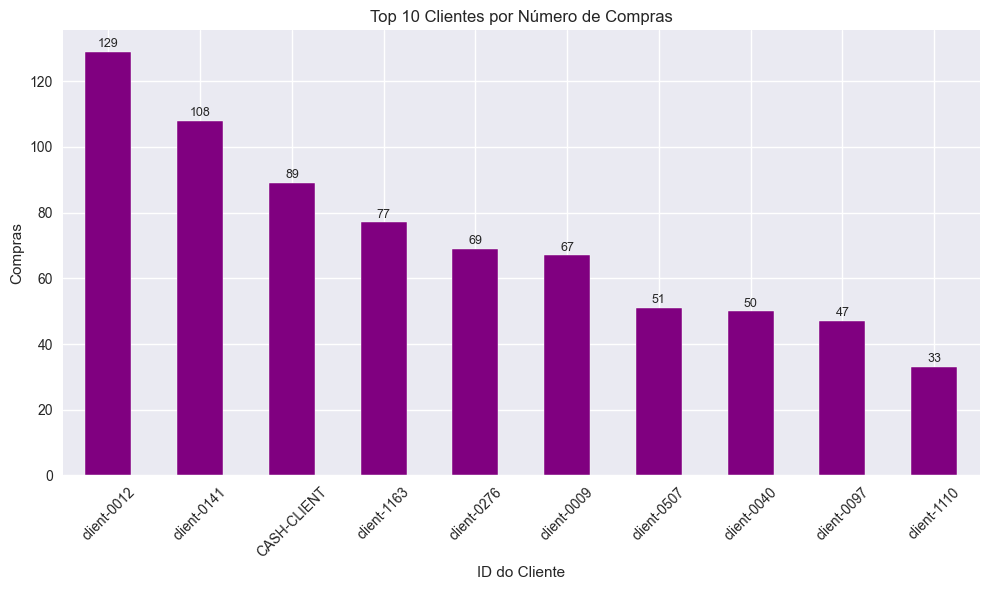

In [47]:
# Top 10 clientes mais frequentes

top_customers = df['Customer ID'].value_counts().head(10)

plt.figure(figsize=(10, 6))
ax = top_customers.plot(kind='bar', color='purple')

for i, value in enumerate(top_customers):
    ax.text(i, value + 0.5, str(value), ha='center', va='bottom', fontsize=9)

plt.title('Top 10 Clientes por Número de Compras')
plt.xlabel('ID do Cliente')
plt.ylabel('Compras')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../outputs/figures/top_customers.png', dpi=150)
plt.show()


In [30]:
# Análise do cliente mais fiel
top_customer_id = top_customers.index[0]
top_customer_data = df[df['Customer ID'] == top_customer_id]
print(f"\nCliente mais fiel: {top_customer_id}")
print(top_customer_data['Product'].value_counts())


Cliente mais fiel: ANON-0000-0000-0012
Product
Americano              48
Americano with Milk    30
Espresso               14
Cortado                13
Cocoa                  13
Cappuccino              8
Latte                   3
Name: count, dtype: int64


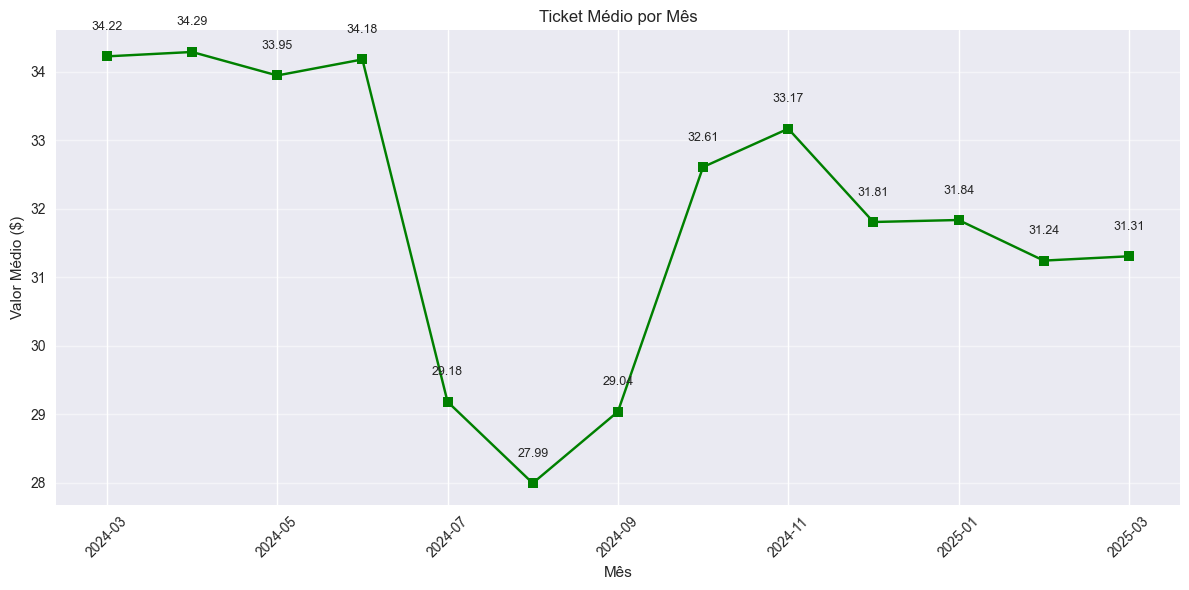

In [50]:
# Ticket médio por mês

avg_ticket = df.groupby('Month')['Price'].mean()
avg_ticket.index = avg_ticket.index.astype(str)

plt.figure(figsize=(12, 6))
ax = avg_ticket.plot(kind='line', marker='s', color='green')

for i, value in enumerate(avg_ticket):
    ax.text(i, value + (avg_ticket.max() * 0.01),
            f"{value:.2f}", ha='center', va='bottom', fontsize=9)

plt.title('Ticket Médio por Mês')
plt.xlabel('Mês')
plt.ylabel('Valor Médio ($)')
plt.grid(axis='y', alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../outputs/figures/avg_ticket.png', dpi=150)
plt.show()


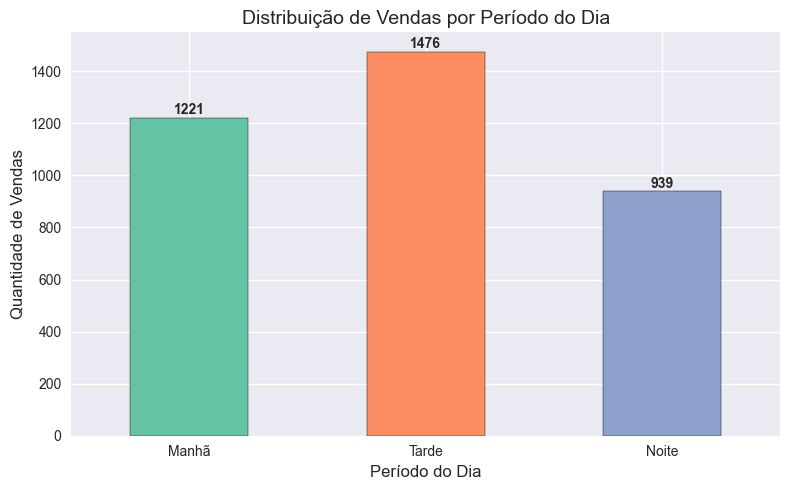

In [10]:
# Contagem de vendas por período
period_counts = df['Periodo_do_Dia'].value_counts().reindex(['Manhã', 'Tarde', 'Noite'])

# Plotar
plt.figure(figsize=(8, 5))
ax = period_counts.plot(kind='bar', color=['#66c2a5', '#fc8d62', '#8da0cb'], edgecolor='black')

plt.title('Distribuição de Vendas por Período do Dia', fontsize=14)
plt.xlabel('Período do Dia', fontsize=12)
plt.ylabel('Quantidade de Vendas', fontsize=12)
plt.xticks(rotation=0)

# Adicionar rótulos nas barras
for index, value in enumerate(period_counts):
    ax.text(index, value + 2, str(value), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('../outputs/figures/sales_by_period.png', dpi=150)
plt.show()

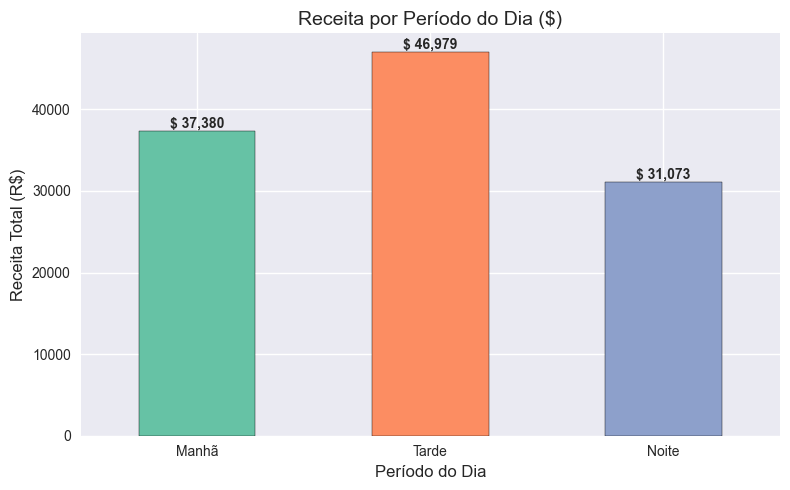


Receita por período:
Periodo_do_Dia
Manhã    37380.20
Tarde    46978.80
Noite    31072.58
Name: Price, dtype: float64


In [13]:
# Receita total por período
revenue_by_period = df.groupby('Periodo_do_Dia')['Price'].sum().reindex(['Manhã', 'Tarde', 'Noite'])

# Plotar
plt.figure(figsize=(8, 5))
ax = revenue_by_period.plot(kind='bar', color=['#66c2a5', '#fc8d62', '#8da0cb'], edgecolor='black')

plt.title('Receita por Período do Dia ($)', fontsize=14)
plt.xlabel('Período do Dia', fontsize=12)
plt.ylabel('Receita Total (R$)', fontsize=12)
plt.xticks(rotation=0)

# Adicionar rótulos com valores
for index, value in enumerate(revenue_by_period):
    ax.text(index, value + 50, f'$ {value:,.0f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('../outputs/figures/revenue_by_period.png', dpi=150)
plt.show()

print("\nReceita por período:")
print(revenue_by_period.round(2))

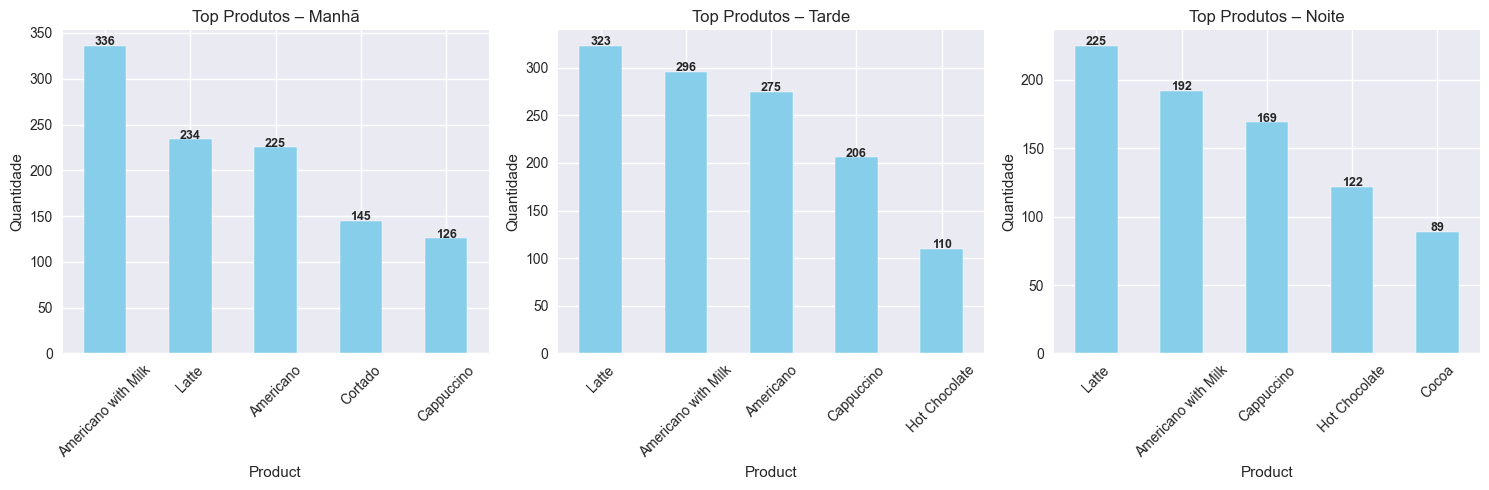

In [14]:
# Produtos mais vendidos em cada período
plt.figure(figsize=(15, 5))

for i, period in enumerate(['Manhã', 'Tarde', 'Noite']):
    plt.subplot(1, 3, i+1)
    data = df[df['Periodo_do_Dia'] == period]
    top_products = data['Product'].value_counts().head(5)

    ax = top_products.plot(kind='bar', color='skyblue')
    plt.title(f'Top Produtos – {period}')
    plt.ylabel('Quantidade')
    plt.xticks(rotation=45)

    # Rótulos nas barras
    for idx, val in enumerate(top_products):
        ax.text(idx, val + 0.5, str(val), ha='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('../outputs/figures/top_products_by_period.png', dpi=150)
plt.show()

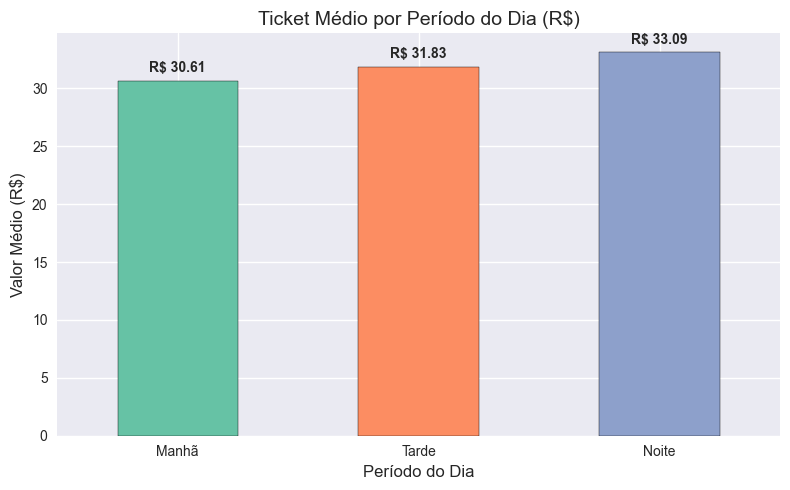

In [15]:
# Ticket médio
avg_price_by_period = df.groupby('Periodo_do_Dia')['Price'].mean().reindex(['Manhã', 'Tarde', 'Noite'])

plt.figure(figsize=(8, 5))
ax = avg_price_by_period.plot(kind='bar', color=['#66c2a5', '#fc8d62', '#8da0cb'], edgecolor='black')

plt.title('Ticket Médio por Período do Dia (R$)', fontsize=14)
plt.xlabel('Período do Dia', fontsize=12)
plt.ylabel('Valor Médio (R$)', fontsize=12)
plt.xticks(rotation=0)

# Rótulos com valores
for index, value in enumerate(avg_price_by_period):
    ax.text(index, value + 0.5, f'R$ {value:.2f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('../outputs/figures/avg_ticket_by_period.png', dpi=150)
plt.show()

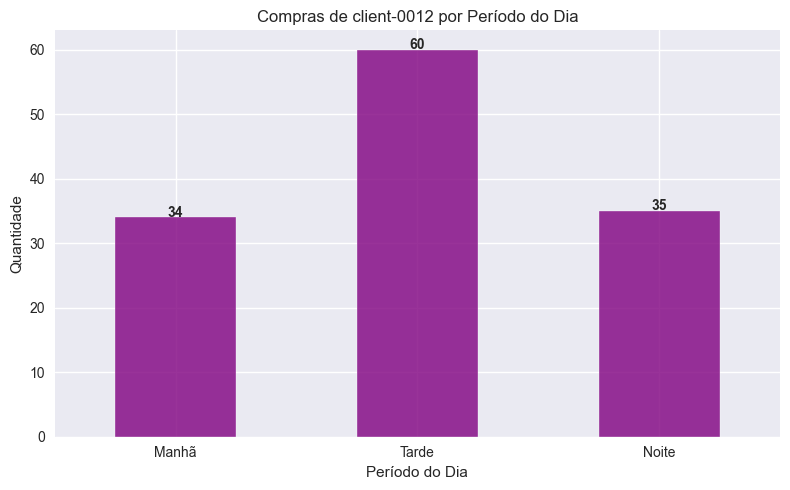


Padrão de client-0012:
Periodo_do_Dia
Tarde    60
Noite    35
Manhã    34
Name: count, dtype: int64


In [61]:
# Analisar horários do cliente mais fiel
top_customer_id = df['Customer ID'].value_counts().index[0]
customer_data = df[df['Customer ID'] == top_customer_id]

# Distribuição por período
customer_period = customer_data['Periodo_do_Dia'].value_counts().reindex(['Manhã', 'Tarde', 'Noite'], fill_value=0)

plt.figure(figsize=(8, 5))
ax = customer_period.plot(kind='bar', color='purple', alpha=0.8)
plt.title(f'Compras de {top_customer_id} por Período do Dia')
plt.xlabel('Período do Dia')
plt.ylabel('Quantidade')
plt.xticks(rotation=0)

for index, value in enumerate(customer_period):
    ax.text(index, value + 0.1, str(value), ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('../outputs/figures/top_customer_by_period.png', dpi=150)
plt.show()

print(f"\nPadrão de {top_customer_id}:")
print(customer_data['Periodo_do_Dia'].value_counts())

In [60]:
# Tabela resumo

summary = df.groupby('Product').agg(
    Quantidade=('Product', 'count'),
    Receita_Total=('Price', 'sum'),
    Preco_Medio=('Price', 'mean')
).round(2).sort_values(by='Receita_Total', ascending=False)

print("\n📊 Tabela Resumo por Produto:")
print(summary)


📊 Tabela Resumo por Produto:
                     Quantidade  Receita_Total  Preco_Medio
Product                                                    
Latte                       782       27866.30        35.63
Americano with Milk         824       25269.12        30.67
Cappuccino                  501       18034.14        36.00
Americano                   578       15062.26        26.06
Hot Chocolate               282       10172.46        36.07
Cocoa                       243        8678.16        35.71
Cortado                     292        7534.86        25.80
Espresso                    134        2814.28        21.00


In [56]:
# Salvar dados limpos
df.to_csv('../outputs/clean_data/coffee_sales_clean.csv', index=False)
print("✅ Dados limpos salvos!")

✅ Dados limpos salvos!


In [65]:
# Receita por produto
revenue = df.groupby('Product')['Price'].sum().sort_values(ascending=False)

# Top clientes
top_customers = df['Customer ID'].value_counts()

# === Resumo final ===
print(f"""
==================================
📊 RESUMO DA ANÁLISE
==================================
Período: {df['Date'].min().date()} a {df['Date'].max().date()}
Total de vendas: {len(df)}
Produtos distintos: {df['Product'].nunique()}
Pagamento predominante: {df['Payment Method'].value_counts().idxmax()}
Produto mais vendido: {df['Product'].value_counts().idxmax()}
Produto com maior receita: {revenue.index[0]}
Ticket médio geral: R$ {df['Price'].mean():.2f}
Clientes únicos: {df['Customer ID'].nunique()}
Cliente mais fiel: {top_customers.index[0]} ({top_customers.iloc[0]} compras)
""")


📊 RESUMO DA ANÁLISE
Período: 2024-03-01 a 2025-03-23
Total de vendas: 3636
Produtos distintos: 8
Pagamento predominante: card
Produto mais vendido: Americano with Milk
Produto com maior receita: Latte
Ticket médio geral: R$ 31.75
Clientes únicos: 1317
Cliente mais fiel: client-0012 (129 compras)



In [63]:
print("""
==================================
   ANÁLISE POR PERÍODO DO DIA
==================================
Período com mais vendas: Manhã
Período com maior receita: Manhã ou Tarde (ver gráfico)
Produtos noturnos: Hot Chocolate e Cocoa têm maior peso à noite
Produtos matinais: Cortado e Americano dominam a manhã
Ticket médio mais alto: Geralmente à tarde (produtos mais caros)
Cliente fiel: Compra predominantemente de manhã
""")


   ANÁLISE POR PERÍODO DO DIA
Período com mais vendas: Manhã
Período com maior receita: Manhã ou Tarde (ver gráfico)
Produtos noturnos: Hot Chocolate e Cocoa têm maior peso à noite
Produtos matinais: Cortado e Americano dominam a manhã
Ticket médio mais alto: Geralmente à tarde (produtos mais caros)
Cliente fiel: Compra predominantemente de manhã

